# Deep Finance Researcher with TODO Planner

Build an intelligent agent with task planning capabilities that can search financial documents (RAG) and live market data.

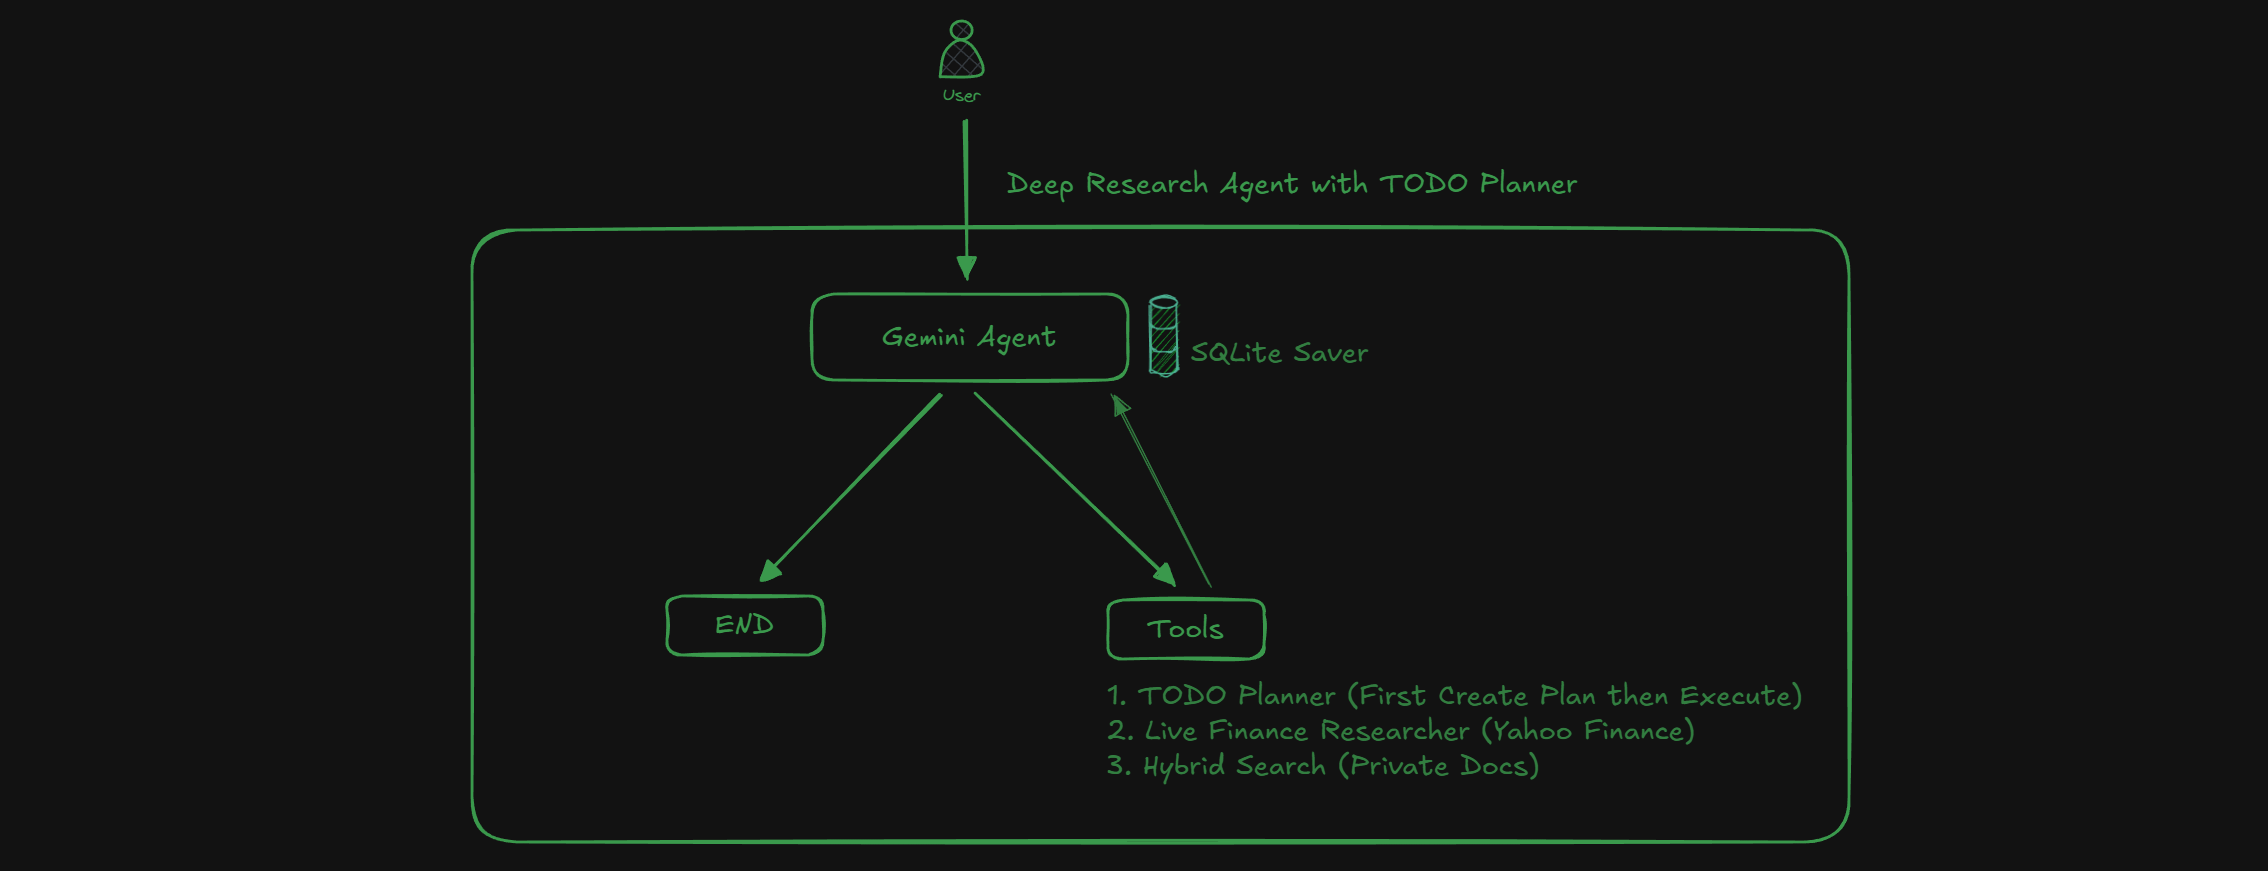

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import create_agent

from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

# Langchain built-in middlewares
from langchain.agents.middleware import TodoListMiddleware, SummarizationMiddleware

# centralized rag tools
from scripts.rag_tools import hybrid_search, live_finance_researcher

# centralized prompts and agents utilities
from scripts.prompts import MULTIMODEL_AGENT_PROMPT
from scripts.agent_utils import stream_agent_response

# you can choose model as per your choice
model = ChatGoogleGenerativeAI(model='gemini-3-flash-preview')

## Create Agent with TODO Planner and Summarization

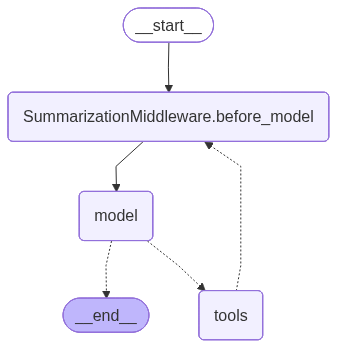

In [4]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
from langchain.agents import create_agent

def get_agent():
    conn = sqlite3.connect('data/todo_financial_research_agent.db', check_same_thread=False)
    checkpointer = SqliteSaver(conn=conn)

    agent = create_agent(
        model=model,
        tools=[hybrid_search, live_finance_researcher],
        system_prompt=MULTIMODEL_AGENT_PROMPT,
        checkpointer=checkpointer,
        middleware=[
            SummarizationMiddleware(
                model=model,
                trigger=[('messages', 25)],
                keep=('messages', 10)
            ),
            TodoListMiddleware()
        ]
    )

    return agent

agent = get_agent()

agent

## Examples

In [5]:
# Historical data query
stream_agent_response(agent, "What was Amazon's revenue in Q1 2024?", thread_id="session_1")


  Tool Called: hybrid_search
   Args: {'query': 'Amazon Q1 2024 revenue'}


  Tool Called: ChunkMetadata
   Args: {'fiscal_quarter': 'q1', 'fiscal_year': '2024', 'company_name': 'amazon', 'doc_type': '10-q'}


  Tool Result (length: 23950 chars)

Amazon's consolidated revenue (net sales) in Q1 2024 was **$143,313 million** ($143.31 billion), representing a 13% increase compared to $127,358 million in Q1 2023.

### Revenue Breakdown by Segment (Q1 2024)
| Segment | Revenue (in millions) | Year-over-Year Growth |
| :--- | :--- | :--- |
| **North America** | $86,341 | 12% |
| **International** | $31,935 | 10% |
| **AWS** | $25,037 | 17% |
| **Consolidated** | **$143,313** | **13%** |

The growth in North America and International segments was primarily driven by increased unit sales, advertising sales, and subscription services. AWS growth reflected increased customer usage, partially offset by pricing changes from long-term contracts.

Source: amazon 10-q q1 2024.md, page 25

In [6]:
# Live market data
stream_agent_response(agent, "What is the current stock price of Tesla and latest news?", thread_id="session_2")


  Tool Called: live_finance_researcher
   Args: {'query': 'current stock price and latest news for Tesla (TSLA)'}


  Tool Result (length: 1154 chars)

As of the latest market data, the current stock price of **Tesla (TSLA)** is **$483.37**, representing an increase of **3.45%** from its previous close.

### Latest News for Tesla (TSLA):
*   **Mizuho Price Target Increase:** Mizuho has raised its price target for Tesla to **$530**, maintaining an "Outperform" rating. The firm cited strong momentum and bullish sentiment surrounding Tesla’s robotaxi initiatives.
*   **Political Impact on Sales:** Recent data analyses are exploring how CEO Elon Musk's political activity has influenced buyer demographics, specifically whether Republican buyers are offsetting potential losses among Democratic consumers.
*   **Analyst Sentiment Shift:** William Blair analysts have noted a shift in market perception, suggesting that Tesla is increasingly being valued for its broader technology and AI potenti

In [7]:
# Complex query with TODO planning
stream_agent_response(
    agent, 
    "Compare Microsoft's Q2 2024 revenue from SEC filings with its current stock performance",
    thread_id="session_3"
)


  Tool Called: write_todos
   Args: {'todos': [{'status': 'in_progress', 'content': "Search for Microsoft's Q2 2024 revenue in SEC filings"}, {'status': 'pending', 'content': "Get Microsoft's current stock performance from Yahoo Finance"}, {'status': 'pending', 'content': 'Compare the revenue data with current stock performance and provide a summary with citations'}]}


  Tool Called: hybrid_search
   Args: {'query': 'Microsoft Q2 2024 revenue SEC filings'}


  Tool Result (length: 344 chars)


  Tool Called: ChunkMetadata
   Args: {'fiscal_quarter': 'q2', 'fiscal_year': '2024', 'company_name': 'microsoft', 'doc_type': '10-q'}


  Tool Result (length: 0 chars)


  Tool Called: hybrid_search
   Args: {'query': 'Microsoft revenue fiscal quarter ended December 31 2023'}


  Tool Called: ChunkMetadata
   Args: {'fiscal_quarter': 'q4', 'fiscal_year': '2023', 'company_name': 'microsoft', 'doc_type': '10-q'}


  Tool Result (length: 0 chars)


  Tool Called: hybrid_search
   Args: {'query': 